In [1]:
import qiskit
# numerics
import numpy as np
# functional programmin tools
import itertools
import functools
import operator
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 125
import seaborn
# data analysis
import pandas as pd
# qiskit 
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator, AerSimulator
from qiskit.quantum_info import Pauli
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Kraus, SuperOp, SparsePauliOp, Operator, DensityMatrix, Statevector
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error
from qiskit.circuit import ParameterVector

# Excercise 3.1 - QAOA

$G=(V,E)$, where $V=\{v_0,v_1,v_2,v_3 \}$ and $E=\{(v_0,v_1), (v_1,v_2), (v_0, v_2), (v_1,v_3), (v_2,v_3)) \}$. The Trotterized time evolution operator is

$$U= \prod_{m=1}^p U_M(\beta_m)U_f(\gamma_m)= exp(-i \beta_1 H_M \Delta t)exp(-i \gamma_1 H_f \Delta t) \cdots exp(-i \beta_p H_M \Delta t)exp(-i \gamma_p H_f \Delta t),$$

for $H_M=\sum_{i=1}^{\vert V \vert} X_i$ with ground state $\ket{+}^{\otimes \vert V \vert}$ and $H_f=\sum_{(u,v) \in E}Z_u Z_v$ with a ground state that encodes the solution to the MaxCut problem.

## Template to (a)

In [2]:
E = [(0, 1), (1, 2), (0, 2), (1, 3), (2, 3)]
V = [0, 1, 2, 3]

#To Do: Generate H_f and H_mix
hf_terms = []
for u, v in E:
    z_term = ['I'] * len(V)
    z_term[u] = 'Z'
    z_term[v] = 'Z'
    hf_terms.append((''.join(z_term), 1.0))
    
hf_op = SparsePauliOp.from_list(hf_terms)

hmix_terms = []
for j in V:
    x_term = ['I'] * len(V)
    x_term[j] = 'X'
    hmix_terms.append((''.join(x_term), 1.0))
hmix_op = SparsePauliOp.from_list(hmix_terms)
            

In [3]:
basis_states = {}
ket = {0: Statevector([1, 0]), 1: Statevector([0, 1])}
for i, bitstring in enumerate(itertools.product([0, 1], repeat=4)):
    state = ket[bitstring[0]]
    for k in range(len(bitstring) - 1):
        state = state.tensor(ket[bitstring[k + 1]])
    basis_states[bitstring] = state
print(basis_states.keys())

dict_keys([(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1)])


In [4]:
#To Do: Calculate exact expectation values
for bitstring, state in basis_states.items():
    e_cost = state.expectation_value(hf_op).real
    print(f"Bitstring: {bitstring}\tH_f: {e_cost}")

Bitstring: (0, 0, 0, 0)	H_f: 5.0
Bitstring: (0, 0, 0, 1)	H_f: 1.0
Bitstring: (0, 0, 1, 0)	H_f: -1.0
Bitstring: (0, 0, 1, 1)	H_f: -1.0
Bitstring: (0, 1, 0, 0)	H_f: -1.0
Bitstring: (0, 1, 0, 1)	H_f: -1.0
Bitstring: (0, 1, 1, 0)	H_f: -3.0
Bitstring: (0, 1, 1, 1)	H_f: 1.0
Bitstring: (1, 0, 0, 0)	H_f: 1.0
Bitstring: (1, 0, 0, 1)	H_f: -3.0
Bitstring: (1, 0, 1, 0)	H_f: -1.0
Bitstring: (1, 0, 1, 1)	H_f: -1.0
Bitstring: (1, 1, 0, 0)	H_f: -1.0
Bitstring: (1, 1, 0, 1)	H_f: -1.0
Bitstring: (1, 1, 1, 0)	H_f: 1.0
Bitstring: (1, 1, 1, 1)	H_f: 5.0


### Answer to (a)
The ground state to $H_f$ is $(0, 1, 1, 0)$ and $(1, 0, 0, 1)$. Hence a solution to the MaxCut problem can be either $(0, 1, 1, 0)$ or $(1, 0, 0, 1)$.

## Template to (c)

In [5]:
# Create the QAOA circuit
def qaoa_circuit(gamma, beta, V, E):
    #To Do: Create QAOA circuit for gamma and beta and a given graph
    qc = QuantumCircuit(4, 0)
    for (u, v) in E:
        qc.cx(u, v)
        qc.rz(2 * gamma, v)
        qc.cx(u, v)
    for j in V:
        qc.rx(2 * beta, j)
        
    qc.measure_all()
    return qc

## Template to (d)

evaluate QAOA should do:

$c_{i,j,k,l}=(\frac{counts}{n-shots})^{1/2}$ for bitstring 'ijkl', such that $\sum_{i,j,k,l=0,1}\vert c_{i,j,k,l} \vert^{2}=1$


get state:
$\ket{\psi}=\sum_{i,j,k,l=0,1}c_{i,j,k,l} \ket{i,j,k,l}$ 


calculate expectation value:
$E=\bra{\psi}H_f \ket{\psi}=\sum_{i,j,k,l=0,1}\vert c_{i,j,k,l} \vert^2 \bra{i,j,k,l}H_f \ket{i,j,k,l}$

In [6]:
# Evaluate the QAOA circuit
def evaluate_qaoa(circuit, n_shots=1000):
    backend = AerSimulator()
    transpiled_qc = transpile(circuit, backend)
    qobj = assemble(transpiled_qc)

    result = backend.run(transpiled_qc, shots = n_shots).result()
    counts = result.get_counts(circuit)
    
    #To Do: Calculate expectation value for a given result
    obj_val = 0
    state = Statevector(np.zeros(16, dtype=complex))
    for bitstring, count in counts.items():
        state += np.sqrt(count / n_shots) * Statevector.from_label(bitstring)
    # state = state.normalize()
    obj_val = state.expectation_value(hf_op).real
    return obj_val

# Optimize QAOA parameters with a grid search
def optimize_qaoa(V, E, n_shots=1000, n_steps=20):
    # Initial parameters, equidistant grid of gamma and beta
    gamma = np.linspace(0, np.pi, n_steps)
    beta = np.linspace(0, np.pi, n_steps)
    obj_value_opt = np.inf
    gamma_opt = np.nan
    beta_opt = np.nan
    state_opt = None
    #To Do: get optimal values for gamma, beta and optimal (minimal) expectation value 
    for gamma_cur in gamma:
        for beta_cur in beta:
            qc = qaoa_circuit(gamma_cur, beta_cur, V, E)
            obj_value = evaluate_qaoa(qc)
            if obj_value_opt > obj_value:
                obj_value_opt = obj_value
                beta_opt = beta_cur
                gamma_opt = gamma_cur
    return gamma_opt, beta_opt, obj_value_opt

In [7]:
# To Do: Run the optimization to get gamma_opt, beta_opt (replace assignment below)
# gamma_opt = 0.0
# beta_opt = 0.0
gamma_opt, beta_opt, obj_value_opt= optimize_qaoa(V, E)
print(f"gamma_opt: {gamma_opt}, beta_opt: {beta_opt}, obj_value_opt: {obj_value_opt}")

gamma_opt: 0.3306939635357677, beta_opt: 0.8267349088394192, obj_value_opt: -0.11999999999999984


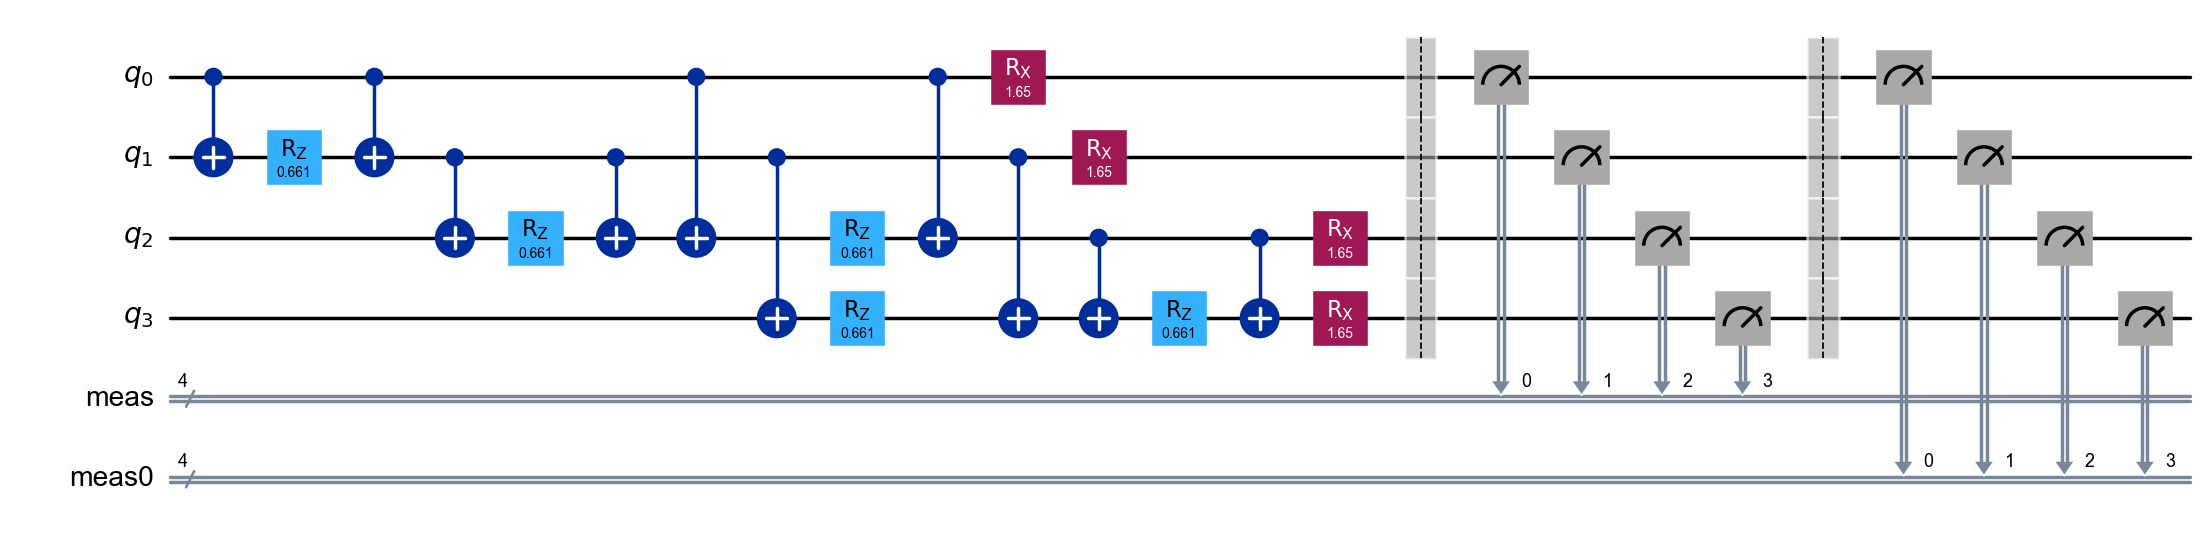

In [8]:
gamma=gamma_opt
beta=beta_opt

#run the circuit for optimal values
qc = qaoa_circuit(gamma, beta, V, E)
qc.measure_all()
qc.draw('mpl')

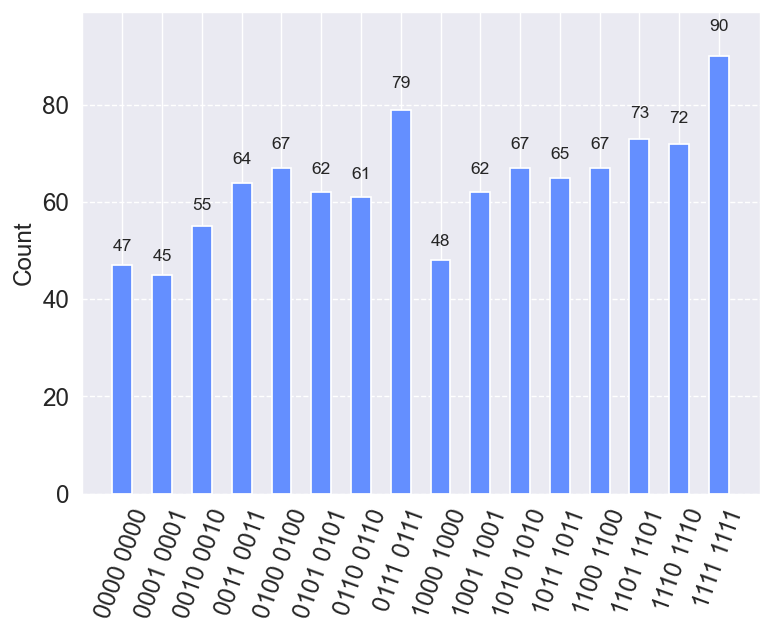

In [9]:
#To Do: get (noiseless) counts for the circuit using gamma_opt, beta_opt.
backend = AerSimulator()
transpiled_qc = transpile(qc, backend)
qobj = assemble(transpiled_qc)

result = backend.run(transpiled_qc).result()
counts = result.get_counts(qc)
plot_histogram(counts)

# Exercise 3.2

In [10]:
from scipy import linalg
from scipy.linalg import expm
from scipy.optimize import minimize

## Template (a)

In [11]:
#define X and Z Matrix
Z=np.array([[1,0],
  [0,-1]])
X=np.array([[0,1],
  [1,0]])

def g_1(s):
    y=np.sin(np.pi*s/2)**2
    return y

def Hamiltonian(s, schedule):
    #to do: get hamiltonian for a certain schedule function
    H = (1 - schedule(s)) * (-Z) + schedule(s) * X
    return H

def get_time_evol_operator(T, Hamiltonian, schedule):
    #to do: get time evolution operator for H until time T
    # M = int(np.max((T / 0.001, 100)))
    M = 100
    dt = T / M
    U = np.zeros((2, 2))
    for m in range(M):
        U = U + T * Hamiltonian(m * dt, schedule) * dt
    U = expm(-1j * U)
    return U

def evolve(psi_initial, operator):
    # to do: evolve state psi_initial under time evol operator
    psi_final = operator * psi_initial
    return psi_final

In [12]:
psi_initial = np.array([1., 0.])
psi_final = evolve(psi_initial, get_time_evol_operator(1.5, Hamiltonian, g_1))
print(f"psi_final={psi_final}")

psi_final=[[-5.39503567e-02+0.54816139j  0.00000000e+00-0.j        ]
 [ 5.55111512e-17-0.83463073j  0.00000000e+00-0.j        ]]


## Template (b)

In [13]:
minus = np.array([1/np.sqrt(2), -1/np.sqrt(2)])

def Fidelity_minus(state):
    # to do: compute fidelity F of input state w.r.t to minus
    F = linalg.norm(np.dot(minus.conj(), state)) ** 2
    return F

print(f"Fidelity_minus={Fidelity_minus(psi_final)}")


Fidelity_minus=0.9575123392436308


## Template (c)

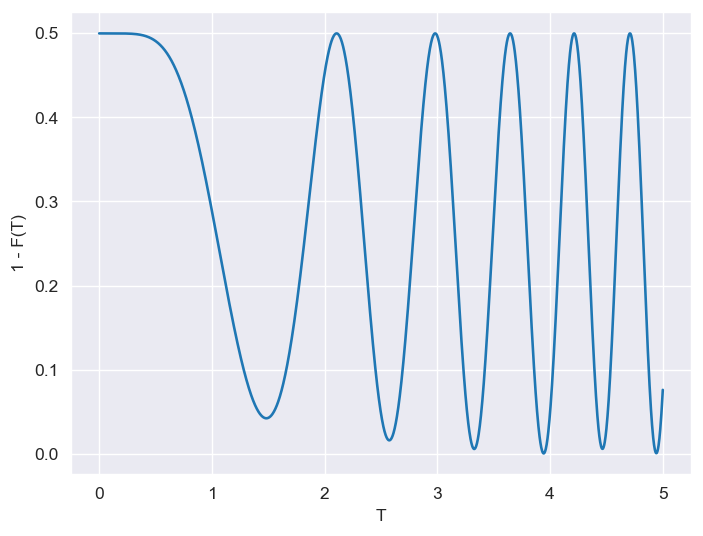

In [14]:
#To Do: plot 1-fidelity
T_range = np.linspace(0, 5, 2000)
one_minus_fidelity_g_1 = []
for T in T_range:
    operator = get_time_evol_operator(T, Hamiltonian, g_1)
    psi_final = evolve(psi_initial, operator)
    one_minus_fidelity_g_1.append(1 - Fidelity_minus(psi_final))
plt.plot(T_range, one_minus_fidelity_g_1)
plt.xlabel("T")
plt.ylabel("1 - F(T)")
plt.show()

### Analyze
For $0 \le T \le 1.5$, the higher $T$ is, the closer is the final state to the ground state. However, for $1.5 \le T \le 2$ the "error" $1 - F(T)$ goes up as $T$ gets larger.

The plot swings between 0 and 0.5. We assume that this has something to do with the inaccuracy of the integral approximation.

## Template (d)

In [15]:
# Repeat with the following schedule

def g_2(s):
    y=np.sin(np.pi*s/2)**4
    return y

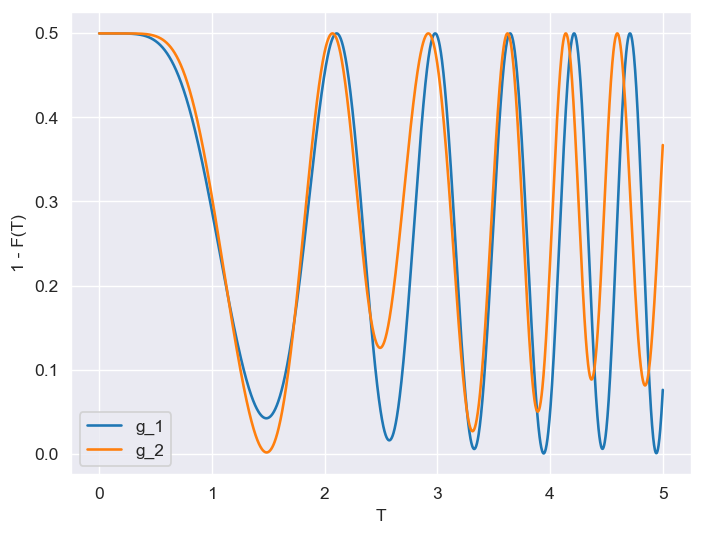

In [16]:
# T_range = np.linspace(0, 2, 200)
one_minus_fidelity_g_2 = []
for T in T_range:
    operator = get_time_evol_operator(T, Hamiltonian, g_2)
    psi_final = evolve(psi_initial, operator)
    one_minus_fidelity_g_2.append(1 - Fidelity_minus(psi_final))
plt.plot(T_range, one_minus_fidelity_g_1, label="g_1")
plt.plot(T_range, one_minus_fidelity_g_2, label="g_2")
plt.xlabel("T")
plt.ylabel("1 - F(T)")
plt.legend()
plt.show()

For $g_2(s) = \sin^4(\pi\frac{s}{2})$, the "error" $1-F(T)$ sinks quicker for $0 < T \le 1.5$ than for $g_1(s) = \sin^2(\pi\frac{s}{2})$, the lowest point is closer to 0, and grows faster for $1.50 < T < 2$.

However, with larger $T$, the "error" of $g_1(s)$ is lower than the "error" of $g_2(s)$ in each period.